# 1. Cel ćwiczenia

In [122]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
from scipy import ndimage
import pandas as pd
import seaborn as snb
from itertools import product
import glob
import os

HARALIC_DISTANCES = [1, 2, 3]
HARALIC_ANGLES = [0, np.pi/4, np.pi/2, 3*np.pi/4]

HARALIC_ANGLES_STRINGS = ['0', 'pi/4', 'pi/2', '3*pi/4']

KSIZE = 6
THETA = np.pi / 1
SIGMA = 3.0
LAMBDA = 5.0
GAMMA = 0.25

In [123]:
# Funkcje haralickie
def calculate_haralick_features(image):
    # Konwersja do obrazu w skali szarości
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Oblicz macierz współwystępowania szarości (GLCM)
    distances = HARALIC_DISTANCES # Wybrane odległości
    angles = HARALIC_ANGLES # Wybrane kąty
    glcm = graycomatrix(gray_image, distances, angles, symmetric=True, normed=True)
    # Oblicz cechy haralickie: kontrast, korelacja, energia, odchylenie standardowe
    contrast = graycoprops(glcm, 'contrast')
    correlation = graycoprops(glcm, 'correlation')
    energy = graycoprops(glcm, 'energy')
    std_dev = graycoprops(glcm, 'homogeneity')
    return contrast, correlation, energy, std_dev

# Filtrowanie obrazu za pomocą filtru Gabora
def apply_gabor_filter(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Parametry filtru Gabora
    ksize = KSIZE
    theta = THETA
    sigma = SIGMA
    lambd = LAMBDA
    gamma = GAMMA
    gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma)
    # Filtracja obrazu przy użyciu filtru Gabora
    filtered_image = cv2.filter2D(gray_image, cv2.CV_8UC3, gabor_kernel)
    return filtered_image

def create_column_names(feature):
    return [f'{feature}_step_{a}_angle_{b}' for a,b in list(product(HARALIC_DISTANCES,HARALIC_ANGLES_STRINGS))]

In [124]:
image_paths = glob.glob("images/basalt/*") + glob.glob("images/granite/*") + glob.glob("images/limestone/*")
image_paths

['images/basalt/istockphoto-1456650485-612x612.jpg',
 'images/basalt/360_F_435371679_BE6Caog7SC6NhCyaK87X7ngurGOwPG8R.jpg',
 'images/basalt/360_F_440295724_nf9K9xW25CbwPmhWXqA70o6vSqIVbb1E.jpg',
 'images/basalt/360_F_306015659_2nyvBRahCSL0b2mojGoO22LIT7FajoNc.jpg',
 'images/basalt/1.jpg',
 'images/basalt/360_F_315052544_Np8JW5Y5XNggXoAuAnH2ioTc9IcKCnfP.jpg',
 'images/granite/depositphotos_38500317-stock-photo-granite-texture.jpg',
 'images/granite/granite-2311854_640.jpg',
 'images/granite/what_is_this_2.jpg',
 'images/granite/Silver+Gray+Granite+Cover+WM+1.jpg',
 'images/granite/what_is_this_3.jpg',
 'images/granite/1000_F_210890250_yXn99stp3wOqHXP751WdwN1hvzqi8BFw.jpg',
 'images/granite/bf0c493bf27bdee9ee25c2290e916d89.jpg',
 'images/granite/what_is_this_1.jpg',
 'images/granite/74eddb85476a60a87706359ad64d7a2d.jpg',
 'images/granite/1.jpg',
 'images/limestone/images.jpeg',
 'images/limestone/Polished.jpg',
 'images/limestone/rough-limestone-5fc4cd2dd3792-1200.jpg',
 'images/limeston

In [125]:
# Wczytanie zestawu obrazów

haralic_features_summary = pd.DataFrame()

# Analiza tekstur dla każdego obrazu
for i, pth in enumerate(image_paths):

    image = cv2.imread(pth)
    # Wybierz obszar obrazu dla analizy tekstur
    region_of_interest = image[100:300, 100:300]
    # Oblicz funkcje haralickie
    contrast, correlation, energy, std_dev = calculate_haralick_features(region_of_interest)

    pth = image_paths[i]
    material = os.path.dirname(pth).removeprefix('images/')

    contrast_df=pd.DataFrame([list(contrast.flatten())],columns=create_column_names('contrast'))
    correlation_df=pd.DataFrame([list(correlation.flatten())],columns=create_column_names('correlation'))
    energy_df=pd.DataFrame([list(energy.flatten())],columns=create_column_names('energy'))
    std_dev_df=pd.DataFrame([list(std_dev.flatten())],columns=create_column_names('std_dev'))

    tmp_df = pd.concat([contrast_df,correlation_df,energy_df,std_dev_df], axis=1)
    tmp_df['material'] = material
    
    if haralic_features_summary.empty:
        haralic_features_summary = tmp_df
    else:
        haralic_features_summary = pd.concat([haralic_features_summary, tmp_df])
    
    # Zastosuj filtr Gabora
    # gabor_result = apply_gabor_filter(region_of_interest)# Wyświetl wyniki analizy tekstur
    # print(f"Analiza tekstur dla obrazu {i+1}")
    # print(f"Kontrast: {contrast}, Korelacja: {correlation}, Energia: {energy}, Odchylenie standardowe: {std_dev}")
    # # Wyświetl obraz oryginalny, obszar analizy, oraz wynik filtracji Gabora
    # plt.figure(figsize=(10, 6))
    # plt.subplot(1, 3, 1)
    # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # plt.title("Obraz Oryginalny")
    # plt.axis("off")
    # plt.subplot(1, 3, 2)
    # plt.imshow(cv2.cvtColor(region_of_interest, cv2.COLOR_BGR2RGB))
    # plt.title("Obszar Analizy Tekstur")
    # plt.axis("off")
    # plt.subplot(1, 3, 3)
    # plt.imshow(gabor_result, cmap='gray')
    # plt.title("Wynik Filtracji Gabora")
    # plt.axis("off")
    # plt.show()

In [126]:
haralic_features_summary = haralic_features_summary.reset_index()
haralic_features_summary = haralic_features_summary.drop(['index'], axis=1)
haralic_features_summary

,contrast_step_1_angle_0,contrast_step_1_angle_pi/4,contrast_step_1_angle_pi/2,contrast_step_1_angle_3*pi/4,contrast_step_2_angle_0,contrast_step_2_angle_pi/4,contrast_step_2_angle_pi/2,contrast_step_2_angle_3*pi/4,contrast_step_3_angle_0,contrast_step_3_angle_pi/4,...,std_dev_step_1_angle_3*pi/4,std_dev_step_2_angle_0,std_dev_step_2_angle_pi/4,std_dev_step_2_angle_pi/2,std_dev_step_2_angle_3*pi/4,std_dev_step_3_angle_0,std_dev_step_3_angle_pi/4,std_dev_step_3_angle_pi/2,std_dev_step_3_angle_3*pi/4,material
0,219.228995,272.861190,171.660955,355.605313,442.780404,272.861190,387.581818,355.605313,577.358426,463.201510,...,0.087038,0.080895,0.099233,0.079316,0.087038,0.069784,0.072882,0.068737,0.065506,basalt
1,311.308342,383.690235,309.949121,388.192495,434.426237,383.690235,434.070000,388.192495,411.566371,426.534665,...,0.068140,0.063669,0.069208,0.065366,0.068140,0.066085,0.065683,0.065655,0.067284,basalt
2,292.991407,233.765688,280.563794,509.579581,509.300227,233.765688,497.998207,509.579581,546.382437,369.392128,...,0.056179,0.056341,0.083734,0.056598,0.056179,0.053339,0.066134,0.054827,0.053077,basalt
3,367.590503,678.666650,520.795101,576.132598,694.501894,678.666650,902.130505,576.132598,809.037107,954.648199,...,0.064778,0.058448,0.058001,0.050932,0.064778,0.052115,0.047096,0.045865,0.050969,basalt
4,61.354221,130.811924,72.223995,97.778238,160.216717,130.811924,191.797778,97.778238,223.218249,267.998852,...,0.132014,0.109915,0.113721,0.099940,0.132014,0.091841,0.080171,0.081322,0.094933,basalt
5,194.742337,177.933941,192.013869,396.777253,436.318737,177.933941,443.707146,396.777253,565.058477,331.440006,...,0.087804,0.083822,0.120112,0.081538,0.087804,0.073145,0.095423,0.072579,0.066151,basalt
6,483.458317,799.936845,572.608367,862.395419,1128.563258,799.936845,1240.108182,862.395419,1502.702183,1447.849148,...,0.076559,0.066642,0.075326,0.062184,0.076559,0.057167,0.055641,0.054705,0.057262,granite
7,438.117764,641.761370,452.910477,658.441277,874.680657,641.761370,893.985859,658.441277,1069.848198,1054.288185,...,0.065049,0.055340,0.065929,0.053756,0.065049,0.049211,0.050133,0.048168,0.049676,granite
8,586.996499,854.198108,641.422736,860.453110,983.124136,854.198108,1011.835999,860.453110,1058.959834,1064.411174,...,0.065720,0.062879,0.067233,0.060454,0.065720,0.058450,0.059204,0.057367,0.059764,granite
9,1942.130704,2545.316356,2326.557312,2860.208000,3445.666540,2545.316356,3527.108838,2860.208000,3117.708756,2948.098944,...,0.033018,0.030132,0.035759,0.029406,0.033018,0.030699,0.032070,0.029756,0.030311,granite


In [127]:
haralic_features_summary.columns

Index(['contrast_step_1_angle_0', 'contrast_step_1_angle_pi/4',
       'contrast_step_1_angle_pi/2', 'contrast_step_1_angle_3*pi/4',
       'contrast_step_2_angle_0', 'contrast_step_2_angle_pi/4',
       'contrast_step_2_angle_pi/2', 'contrast_step_2_angle_3*pi/4',
       'contrast_step_3_angle_0', 'contrast_step_3_angle_pi/4',
       'contrast_step_3_angle_pi/2', 'contrast_step_3_angle_3*pi/4',
       'correlation_step_1_angle_0', 'correlation_step_1_angle_pi/4',
       'correlation_step_1_angle_pi/2', 'correlation_step_1_angle_3*pi/4',
       'correlation_step_2_angle_0', 'correlation_step_2_angle_pi/4',
       'correlation_step_2_angle_pi/2', 'correlation_step_2_angle_3*pi/4',
       'correlation_step_3_angle_0', 'correlation_step_3_angle_pi/4',
       'correlation_step_3_angle_pi/2', 'correlation_step_3_angle_3*pi/4',
       'energy_step_1_angle_0', 'energy_step_1_angle_pi/4',
       'energy_step_1_angle_pi/2', 'energy_step_1_angle_3*pi/4',
       'energy_step_2_angle_0', 'energy_s

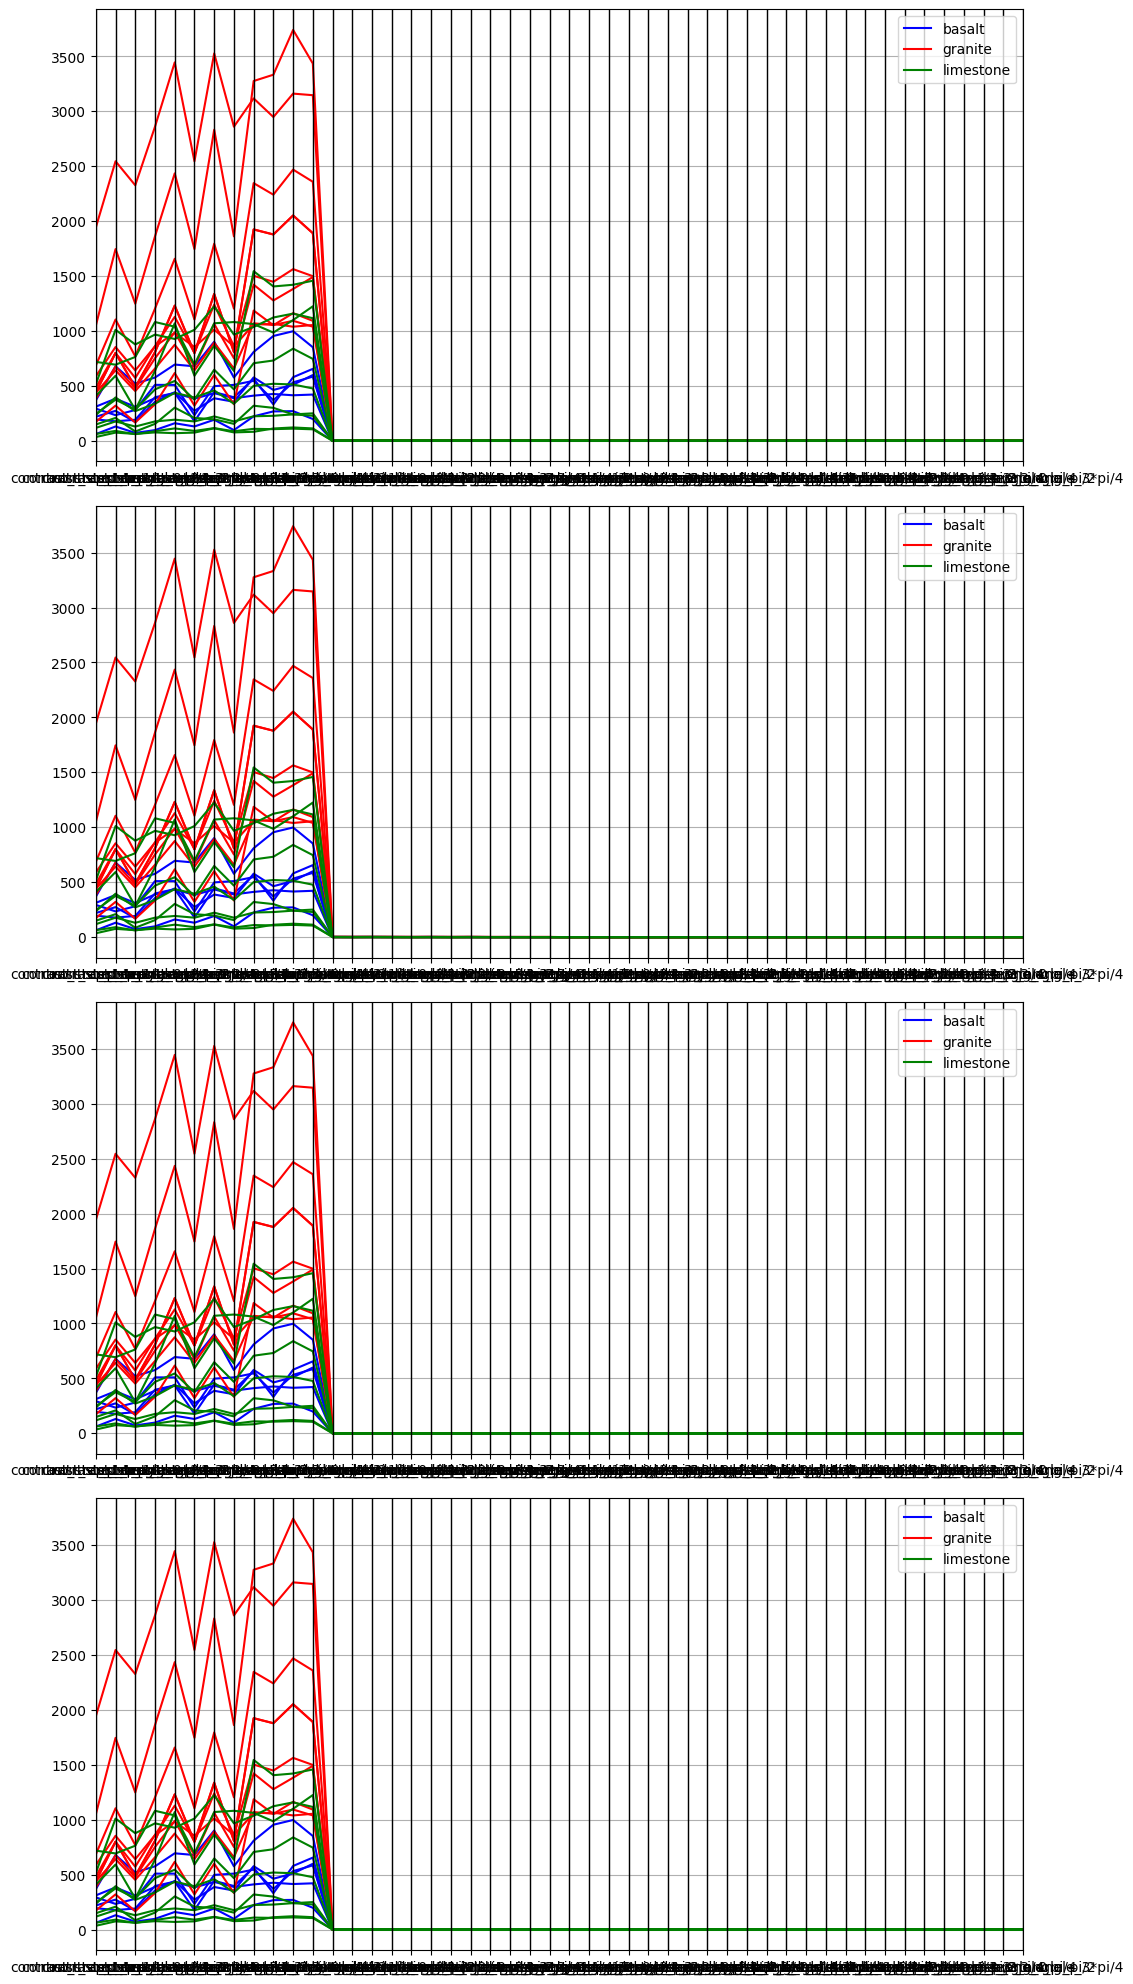

In [128]:
from pandas.plotting import parallel_coordinates

fig, axes = plt.subplots(4)
fig.set_size_inches(10,20)
fig.tight_layout()

for idx, feature in enumerate(['contrast', 'correlation', 'energy', 'std_dev']):
    parallel_coordinates(frame=haralic_features_summary, class_column='material', color=['blue', 'red', 'green'], ax=axes[idx])

In [129]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(haralic_features_summary.drop(['material'],axis=1), haralic_features_summary['material'])
models = []


In [130]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(18, 48)
(7, 48)
(18,)
(7,)


In [131]:
model1 = DecisionTreeClassifier()
model1.fit(X_train, y_train)
predictions = model1.predict(X_test)

acc1 = accuracy_score(predictions, y_test)
models.append({'model':model1, 'accuracy_score':acc1, 'name':"DecisionTreeClassifier"})

[Text(0.5, 0.875, 'contrast_step_3_angle_pi/4 <= 1019.131\ngini = 0.642\nsamples = 18\nvalue = [4, 8, 6]\nclass = granite'),
 Text(0.2, 0.625, 'correlation_step_1_angle_3*pi/4 <= 0.531\ngini = 0.494\nsamples = 9\nvalue = [4, 0, 5]\nclass = limestone'),
 Text(0.1, 0.375, 'gini = 0.0\nsamples = 4\nvalue = [0, 0, 4]\nclass = limestone'),
 Text(0.3, 0.375, 'energy_step_2_angle_3*pi/4 <= 0.014\ngini = 0.32\nsamples = 5\nvalue = [4, 0, 1]\nclass = basalt'),
 Text(0.2, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]\nclass = limestone'),
 Text(0.4, 0.125, 'gini = 0.0\nsamples = 4\nvalue = [4, 0, 0]\nclass = basalt'),
 Text(0.8, 0.625, 'contrast_step_2_angle_pi/2 <= 879.994\ngini = 0.198\nsamples = 9\nvalue = [0, 8, 1]\nclass = granite'),
 Text(0.7, 0.375, 'correlation_step_3_angle_pi/4 <= 0.681\ngini = 0.5\nsamples = 2\nvalue = [0, 1, 1]\nclass = granite'),
 Text(0.6, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]\nclass = limestone'),
 Text(0.8, 0.125, 'gini = 0.0\nsamples = 1\nvalue 

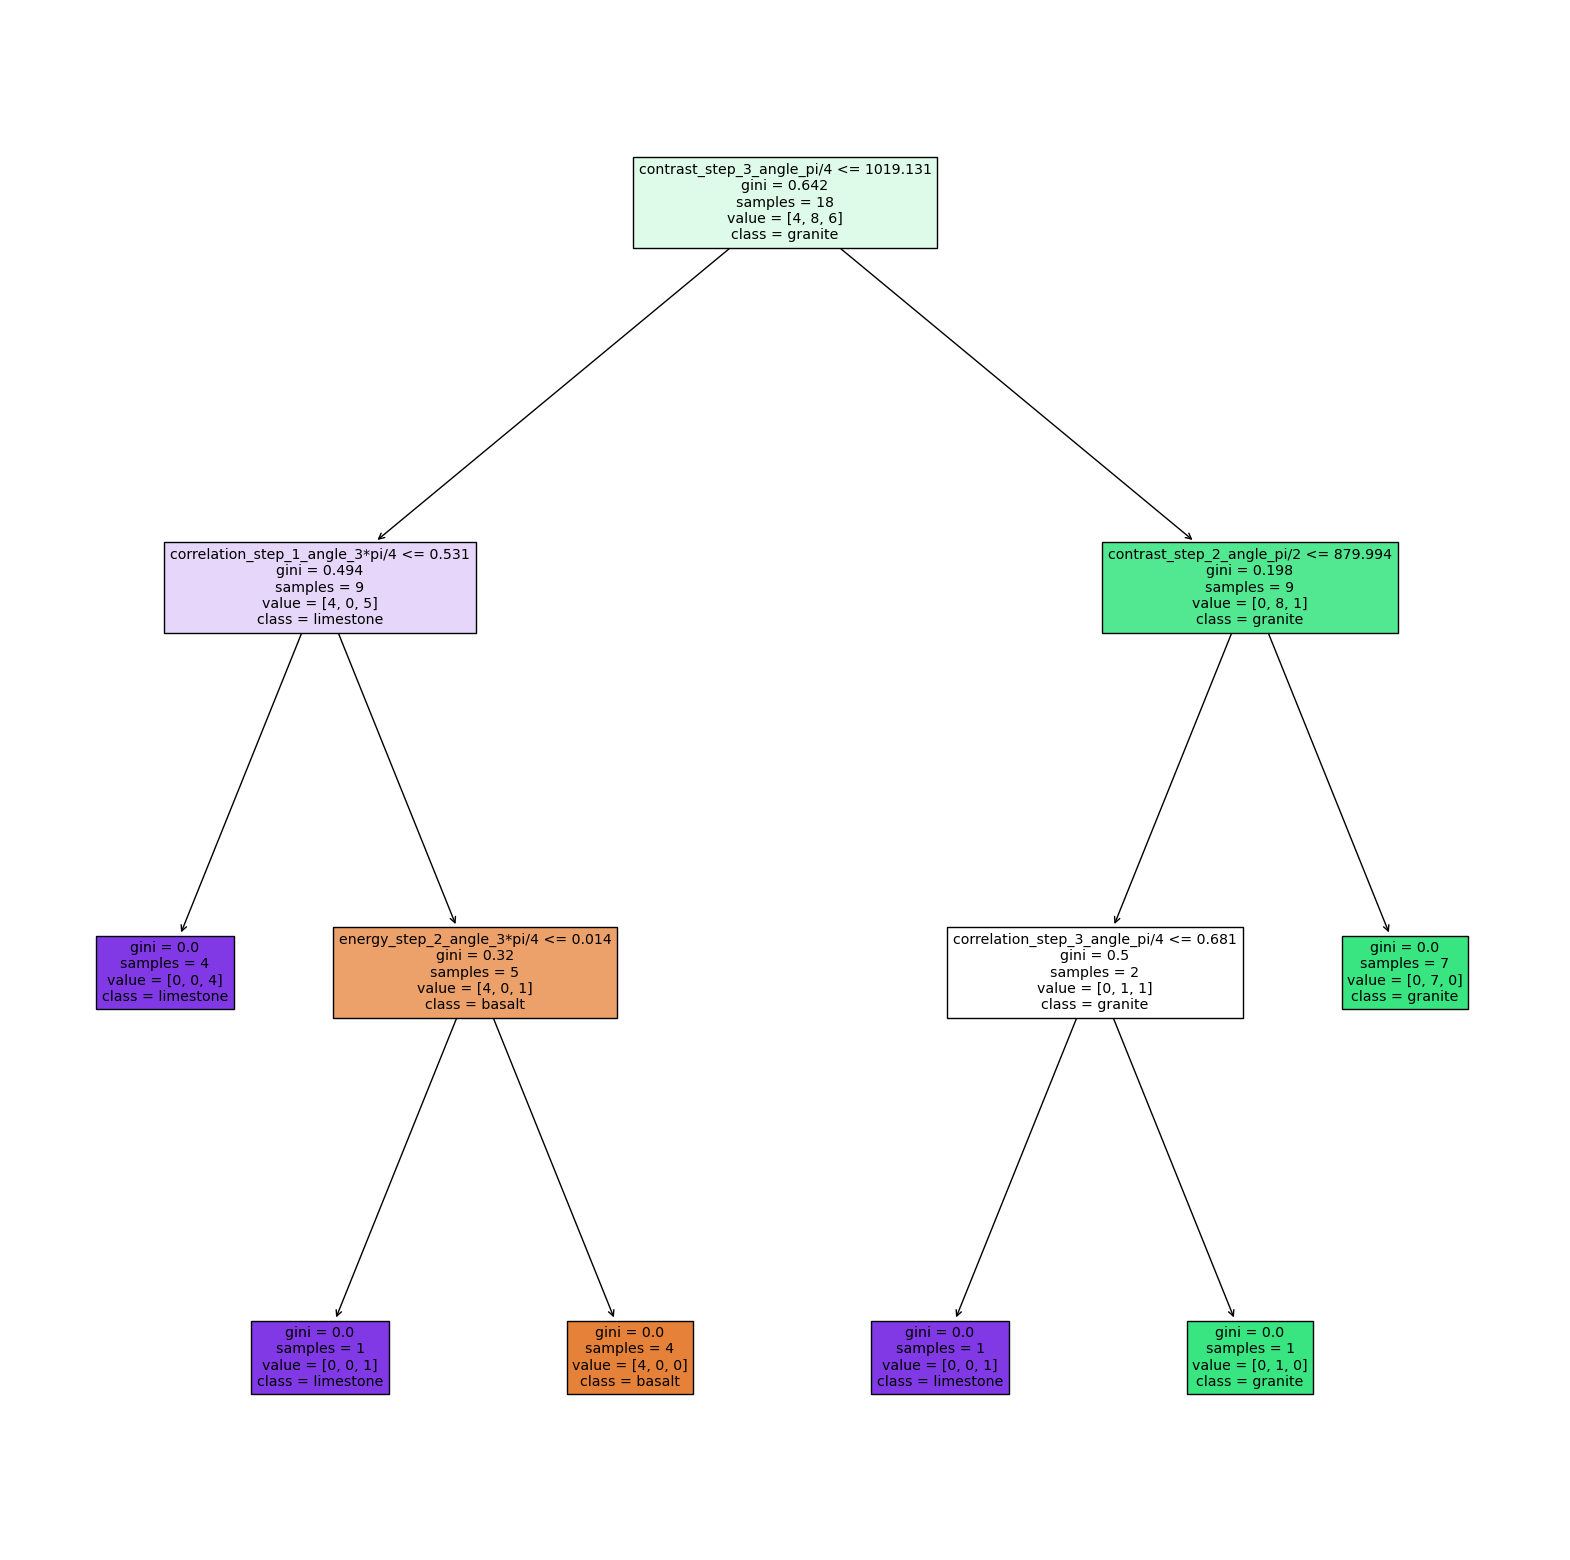

In [132]:
plt.figure(figsize = (20,20))
plot_tree(model1, feature_names=X_train.columns, class_names=y_train.unique() ,filled = True)

In [133]:
model2 = GradientBoostingClassifier(learning_rate=0.2)
model2.fit(X_train, y_train)
predictions = model2.predict(X_test)

acc2 = accuracy_score(predictions, y_test)
models.append({'model':model2, 'accuracy_score':acc2, 'name':"GradientBoostingClassifier"})

In [134]:
from sklearn.svm import SVC
model3 = SVC()
model3.fit(X_train, y_train)
predictions = model3.predict(X_test)

acc3 = accuracy_score(predictions, y_test)
models.append({'model':model3, 'accuracy_score':acc3, 'name':"SVC"})

In [135]:
from sklearn.linear_model import LogisticRegressionCV
model4 = LogisticRegressionCV(verbose=False)
model4.fit(X_train, y_train)
predictions = model4.predict(X_test)

acc4 = accuracy_score(predictions, y_test)
models.append({'model':model4, 'accuracy_score':acc4, 'name':"LogisticRegressionCV"})

/home/michal/University/piao_mgr/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/michal/University/piao_mgr/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michal/University/piao_mgr/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

In [136]:
from sklearn.neighbors import KNeighborsClassifier
model5 = KNeighborsClassifier(n_neighbors=7, leaf_size=30)
model5.fit(X_train, y_train)
predictions = model5.predict(X_test)

acc5 = accuracy_score(predictions, y_test)
models.append({'model':model5, 'accuracy_score':acc5, 'name':"KNeighborsClassifier"})

In [137]:
from sklearn.naive_bayes import GaussianNB
model6 = GaussianNB()
model6.fit(X_train, y_train)
predictions = model6.predict(X_test)

acc6 = accuracy_score(predictions, y_test)
models.append({'model':model6, 'accuracy_score':acc6, 'name':"GaussianNB"})

In [138]:
the_best_model = max(models, key=lambda x: x['accuracy_score'])
the_best_model

{'model': KNeighborsClassifier(n_neighbors=7),
 'accuracy_score': 0.7142857142857143,
 'name': 'KNeighborsClassifier'}

In [139]:
the_best_model = the_best_model['model']

In [140]:
image = cv2.imread('images/depositphotos_36517671-stock-photo-basalt-stone-texture.jpg')
# Wybierz obszar obrazu dla analizy tekstur
region_of_interest = image[100:300, 100:300]
# Oblicz funkcje haralickie
contrast, correlation, energy, std_dev = calculate_haralick_features(region_of_interest)

contrast_df=pd.DataFrame([list(contrast.flatten())],columns=create_column_names('contrast'))
correlation_df=pd.DataFrame([list(correlation.flatten())],columns=create_column_names('correlation'))
energy_df=pd.DataFrame([list(energy.flatten())],columns=create_column_names('energy'))
std_dev_df=pd.DataFrame([list(std_dev.flatten())],columns=create_column_names('std_dev'))

object = pd.concat([contrast_df,correlation_df,energy_df,std_dev_df], axis=1)

the_best_model.predict(object)

array(['basalt'], dtype=object)

In [142]:
import pickle as pckl
with open("DTC_model.pkl", 'wb') as f:
    pckl.dump(the_best_model, f)